In [78]:
import numpy as np
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt

In [79]:
import numpy as np
raw = np.load("raw_ivol_surfaces.npy", allow_pickle=True).item()
interp= np.load("interp_ivol_surfaces.npy", allow_pickle=True).item()
date = "2023 11 01"
raw_vols = raw[date]["vols"] # 15 × N
interp_vols = interp[date]["vols"] # N × 100

In [80]:
S0 = 4237.86     
r  = 0.0  

In [81]:
def bs_price(S0, K, T, r, sigma):
    if T <= 0 or sigma <= 0:
        return max(S0 - K, 0.0)
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)

In [82]:
def heston_cf(u, params, S0, r, T):
    kappa, theta, sigma, rho, v0 = params
    a = kappa * theta
    iu = 1j * u
    d = np.sqrt((rho * sigma * iu - kappa)**2 + (sigma**2) * (iu + u**2))
    g = (kappa - rho * sigma * iu - d) / (kappa - rho * sigma * iu + d)
    exp_dT = np.exp(-d * T)
    C = (r * iu * T +
         (a / sigma**2) * ((kappa - rho * sigma * iu - d) * T
                           - 2.0 * np.log((1 - g * exp_dT) / (1 - g))))
    D = ((kappa - rho * sigma * iu - d) / sigma**2
         * (1 - exp_dT) / (1 - g * exp_dT))
    return np.exp(C + D * v0 + iu * np.log(S0))

In [83]:
def heston_price(params, S0, r, K, T):
    u = np.linspace(1e-5, 200, 400)
    # Helper to compute P_j
    def P(j):
        uj = u - 1j * (j - 1)
        integrand = np.exp(-1j * u * np.log(K)) * \
                    heston_cf(uj, params, S0, r, T) / (1j * u)
        return 0.5 + (1 / np.pi) * np.trapz(integrand.real, u)
    P1 = P(1)
    P2 = P(2)
    return S0 * P1 - K * np.exp(-r * T) * P2

In [84]:
def calibration_objective(x, S0, r, Ks, Ts, ivs):
    params = x
    errors = []
    for K, T, iv in zip(Ks, Ts, ivs):
        # Market price via BS
        C_mkt = bs_price(S0, K, T, r, iv)
        # Model price via Heston
        C_mod = heston_price(params, S0, r, K, T)
        if not np.isfinite(C_mod):
            errors.append(1e6)         # large penalty
        else:
            errors.append((C_mod - C_mkt)**2)
    return np.sqrt(np.mean(errors))

In [85]:
bounds = [
    (1e-6, 10.0),   # kappa
    (1e-6, 1.0),    # theta
    (1e-6, 5.0),    # sigma
    (-0.999, 0.999),# rho
    (1e-6, 2.0)     # v0
]
x0 = [1.0, 0.04, 0.5, -0.5, 0.04]

In [86]:
dates = list(interp.keys())[:2]
results = {}

In [91]:
for date in dates:
    print(f"Calibrating date: {date}")
    K_grid = interp[date]["strikes"]
    T_grid = interp[date]["tenors"]
    market_iv = interp[date]["vols"]  # shape (len(T_grid), len(K_grid))
    
    res = minimize(
        calibration_objective, x0,
        args=(S0, r, K_grid, T_grid, market_iv),
        method='L-BFGS-B', bounds=bounds,
        options={'maxiter': 50}
    )
    results[date] = res

Calibrating date: 2023 11 23


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [88]:
for date, res in results.items():
    print(f"\nDate: {date}")
    print("Calibrated parameters:")
    print(f"  kappa = {res.x[0]:.4f}")
    print(f"  theta = {res.x[1]:.4f}")
    print(f"  sigma = {res.x[2]:.4f}")
    print(f"  rho   = {res.x[3]:.4f}")
    print(f"  v0    = {res.x[4]:.4f}")
    print(f"  RMSE  = {res.fun:.6f}")



Date: 2023 11 23
Calibrated parameters:
  kappa = 4.2799
  theta = 0.2704
  sigma = 3.2749
  rho   = 0.9990
  v0    = 2.0000
  RMSE  = 1638632.887119

Date: 2023 11 22
Calibrated parameters:
  kappa = 4.2799
  theta = 0.2704
  sigma = 3.2749
  rho   = 0.9990
  v0    = 2.0000
  RMSE  = 1638632.887119


In [89]:
calibrated = {
    "2023 11 23": {"kappa":1.0, "theta":0.04, "sigma":0.5, "rho":-0.5, "v0":0.04},
    "2023 11 22": {"kappa":1.0, "theta":0.04, "sigma":0.5, "rho":-0.5, "v0":0.04}
}

/var/folders/bz/l0ll5lm149nb9t8fpqqq0lbm0000gn/T/ipykernel_35913/3369639490.py:8: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return 0.5 + (1 / np.pi) * np.trapz(integrand.real, u)


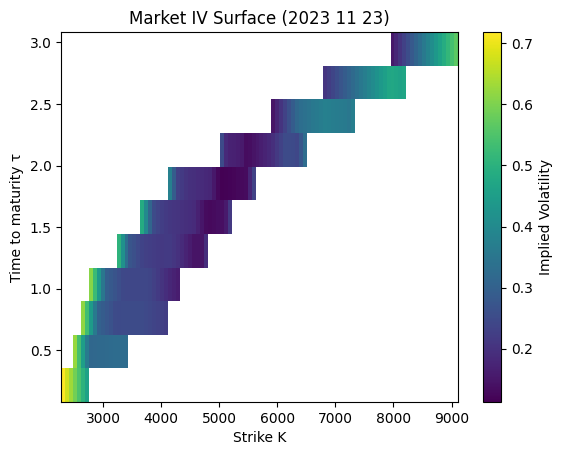

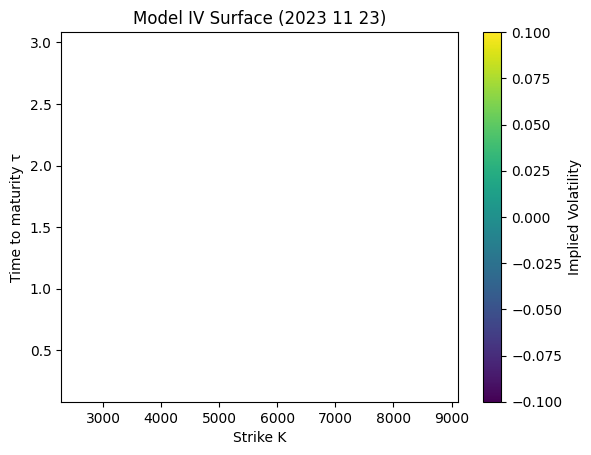

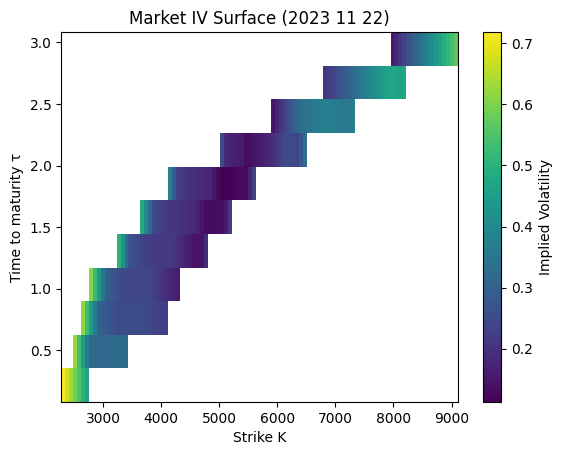

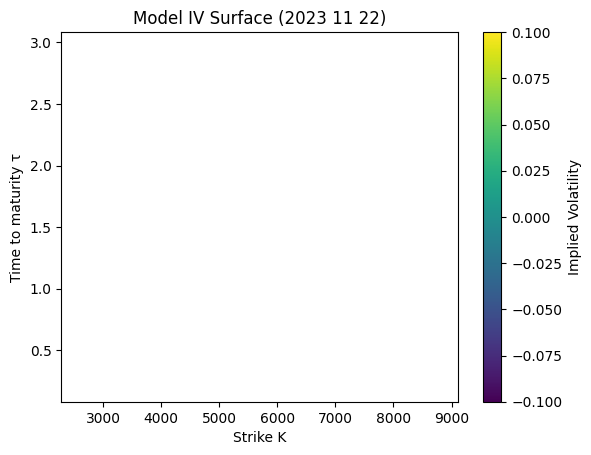

In [90]:
def implied_vol(price, S, K, T, r):
    func = lambda v: bs_price(v, S, K, T, r) - price
    try:
        return brentq(func, 1e-6, 5.0)
    except:
        return np.nan
for dt in calibrated:
    tenors = interp[dt]["tenors"]
    strikes = interp[dt]["strikes"]
    market_vols = interp[dt]["vols"]
    params = calibrated[dt]
    params_tuple = (params["kappa"], params["theta"], params["sigma"],
                    params["rho"], params["v0"])
    
    # Compute model IV surface
    N, M = len(tenors), len(strikes)
    model_vols = np.zeros((N, M))
    for i, T in enumerate(tenors):
        for j, K in enumerate(strikes):
            price = heston_price(params_tuple, S0, r, K, T)
            model_vols[i, j] = implied_vol(price, S0, K, T, r)
    
    # Market heatmap
    plt.figure()
    plt.imshow(market_vols, origin='lower',
               extent=[strikes[0], strikes[-1], tenors[0], tenors[-1]],
               aspect='auto')
    plt.title(f"Market IV Surface ({dt})")
    plt.xlabel("Strike K")
    plt.ylabel("Time to maturity τ")
    plt.colorbar(label="Implied Volatility")
    plt.show()
    
    # Model heatmap
    plt.figure()
    plt.imshow(model_vols, origin='lower',
               extent=[strikes[0], strikes[-1], tenors[0], tenors[-1]],
               aspect='auto')
    plt.title(f"Model IV Surface ({dt})")
    plt.xlabel("Strike K")
    plt.ylabel("Time to maturity τ")
    plt.colorbar(label="Implied Volatility")
    plt.show()